In [1]:
!pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 43.1 MB/s eta 0:00:00


In [17]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import cv2

In [3]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
n_epochs = 30
n_layers = 1

SAVE_PATH = '/content/drive/MyDrive/Colab Notebooks/QML Project'
                             # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

In [19]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist

(train_images,train_labels),(test_images, test_labels) = fashion_mnist.load_data()
# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Specify the number of samples you want to use
train_size = 1500  # Use 2000 samples for training
test_size = 500    # Use 200 samples for testing

# Slice the datasets
train_images = train_images[:train_size]
train_labels = train_labels[:train_size]
test_images = test_images[:test_size]
test_labels = test_labels[:test_size]

# Add extra dimension for convolution channels
train_images = np.expand_dims(train_images, axis=-1)  # Shape: (batch_size, 28, 28, 1)
test_images = np.expand_dims(test_images, axis=-1)    # Shape: (batch_size, 28, 28, 1)



In [20]:
print("Shape of training images:", train_images.shape)
print("Shape of testing images:", test_images.shape)

Shape of training images: (1500, 28, 28, 1)
Shape of testing images: (500, 28, 28, 1)


In [21]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [22]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out


In [23]:
from tqdm import tqdm

if PREPROCESS == False:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for img in tqdm(train_images, desc="Training Images"):
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for img in tqdm(test_images, desc="Test Images"):
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)

# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")


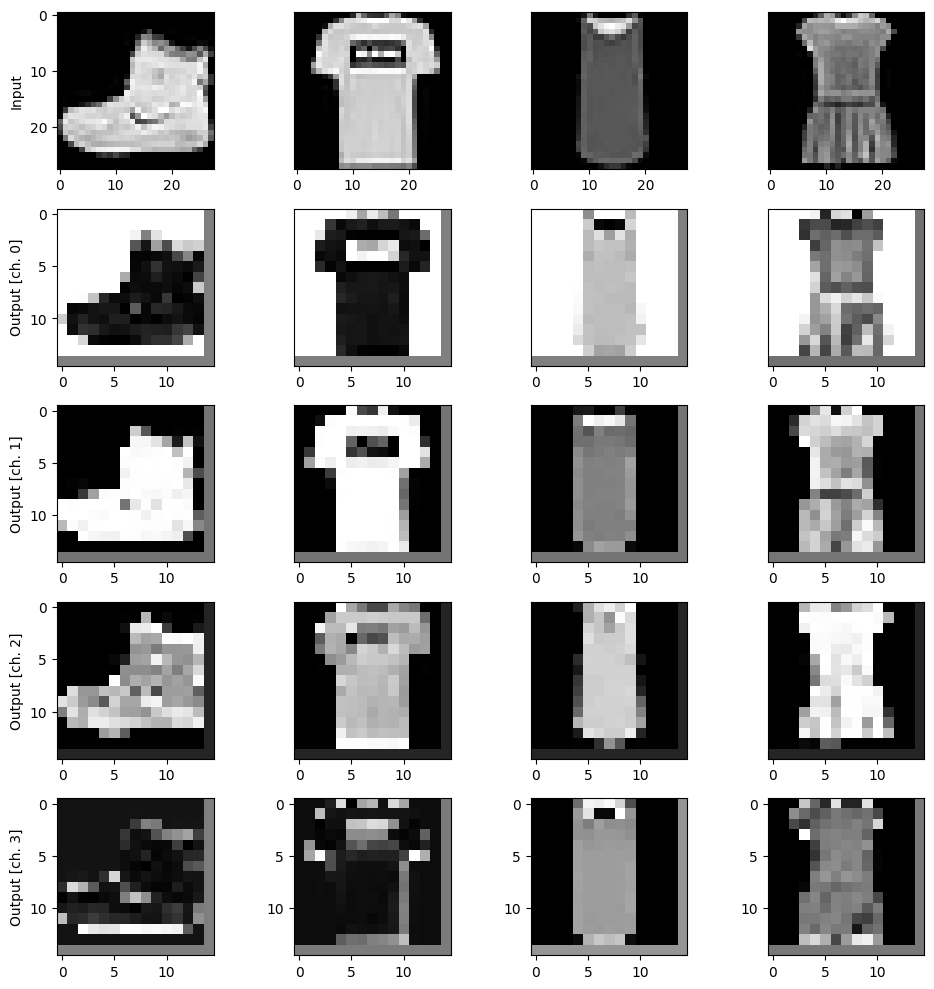

In [24]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [43]:
def MyModel():
    """Initializes and returns a custom Keras model
    #which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


In [44]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
375/375 - 1s - 3ms/step - accuracy: 0.6580 - loss: 0.9729 - val_accuracy: 0.7460 - val_loss: 0.6695
Epoch 2/30
375/375 - 1s - 2ms/step - accuracy: 0.7927 - loss: 0.5993 - val_accuracy: 0.7760 - val_loss: 0.5892
Epoch 3/30
375/375 - 1s - 2ms/step - accuracy: 0.8353 - loss: 0.5028 - val_accuracy: 0.7940 - val_loss: 0.5512
Epoch 4/30
375/375 - 1s - 2ms/step - accuracy: 0.8600 - loss: 0.4410 - val_accuracy: 0.8060 - val_loss: 0.5285
Epoch 5/30
375/375 - 1s - 2ms/step - accuracy: 0.8767 - loss: 0.3944 - val_accuracy: 0.8080 - val_loss: 0.5140
Epoch 6/30
375/375 - 1s - 2ms/step - accuracy: 0.8860 - loss: 0.3565 - val_accuracy: 0.8060 - val_loss: 0.5045
Epoch 7/30
375/375 - 1s - 3ms/step - accuracy: 0.8993 - loss: 0.3246 - val_accuracy: 0.8020 - val_loss: 0.4984
Epoch 8/30
375/375 - 1s - 2ms/step - accuracy: 0.9120 - loss: 0.2971 - val_accuracy: 0.8060 - val_loss: 0.4950
Epoch 9/30
375/375 - 1s - 2ms/step - accuracy: 0.9167 - loss: 0.2729 - val_accuracy: 0.8080 - val_loss: 0.4936
E

In [45]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
375/375 - 1s - 3ms/step - accuracy: 0.6200 - loss: 1.1083 - val_accuracy: 0.7400 - val_loss: 0.7716
Epoch 2/30
375/375 - 1s - 2ms/step - accuracy: 0.7540 - loss: 0.7211 - val_accuracy: 0.7640 - val_loss: 0.6750
Epoch 3/30
375/375 - 1s - 2ms/step - accuracy: 0.7913 - loss: 0.6173 - val_accuracy: 0.7720 - val_loss: 0.6294
Epoch 4/30
375/375 - 1s - 2ms/step - accuracy: 0.8167 - loss: 0.5532 - val_accuracy: 0.7860 - val_loss: 0.6015
Epoch 5/30
375/375 - 1s - 2ms/step - accuracy: 0.8353 - loss: 0.5071 - val_accuracy: 0.7900 - val_loss: 0.5830
Epoch 6/30
375/375 - 1s - 2ms/step - accuracy: 0.8467 - loss: 0.4713 - val_accuracy: 0.7940 - val_loss: 0.5704
Epoch 7/30
375/375 - 1s - 3ms/step - accuracy: 0.8587 - loss: 0.4421 - val_accuracy: 0.7940 - val_loss: 0.5617
Epoch 8/30
375/375 - 1s - 3ms/step - accuracy: 0.8667 - loss: 0.4176 - val_accuracy: 0.7900 - val_loss: 0.5556
Epoch 9/30
375/375 - 1s - 3ms/step - accuracy: 0.8700 - loss: 0.3964 - val_accuracy: 0.8000 - val_loss: 0.5514
E

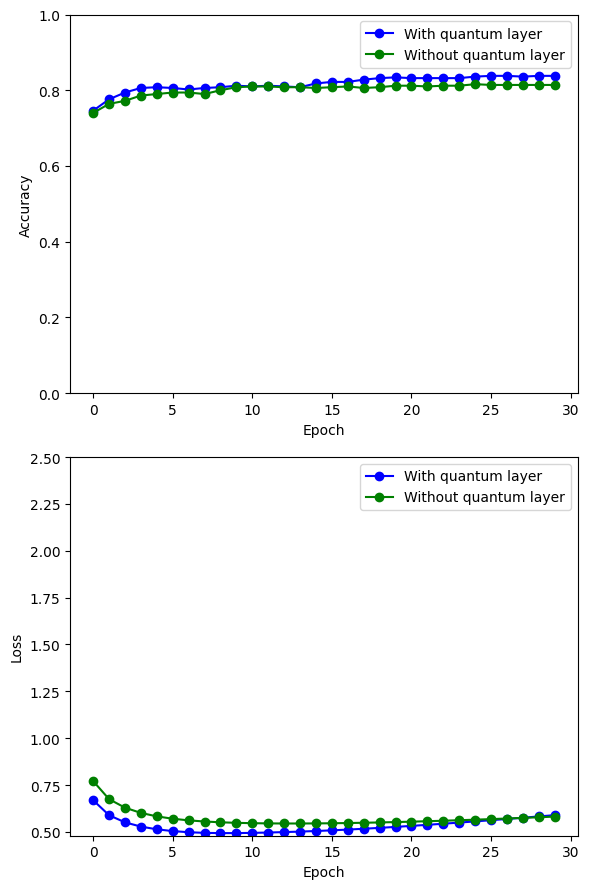

In [46]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()